## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #print(gray.shape)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

## And so on and so forth...

(720, 1280, 3)


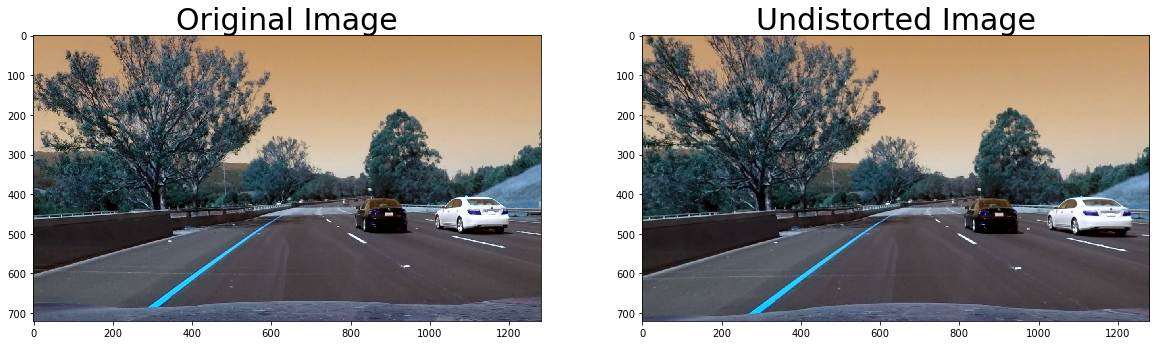

In [7]:
fname = "../test_images/test6.jpg"
img = cv2.imread(fname)
print(img.shape)
ret, cameraMat, distortCoef,rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]), None, None)
undist_img = cv2.undistort(img, cameraMat, distortCoef, None, cameraMat)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)

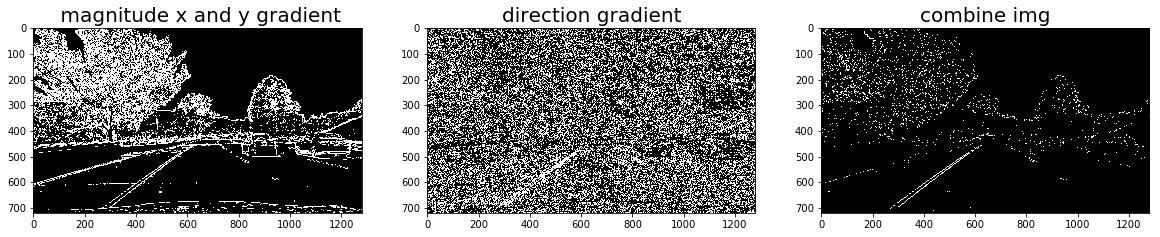

In [20]:
gray_img = cv2.cvtColor(undist_img, cv2.COLOR_BGR2GRAY)
sobel_kernel = 5
sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0,sobel_kernel)
sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1,sobel_kernel)
sobelxy = np.sqrt(np.square(sobelx)+np.square(sobely)) 

abs_sobelx = np.absolute(sobelx)
abs_sobely = np.absolute(sobely)
dir_grad = np.arctan2(abs_sobely, abs_sobelx)

scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
scaled_sobelxy = np.uint8(255*sobelxy/np.max(sobelxy))

thres_min = 20
thres_max = 120
thres_min_arc = 0.7
thres_max_arc = 1.3

binary_sobelx = np.zeros_like(scaled_sobelx)
binary_sobely = np.zeros_like(scaled_sobely)
binary_sobelxy = np.zeros_like(scaled_sobelxy)
binary_dir_grad = np.zeros_like(dir_grad)
binary_combine = np.zeros_like(dir_grad)
binary_sobelx[(scaled_sobelx >= thres_min) & (scaled_sobelx <= thres_max)] = 1
binary_sobely[(scaled_sobely >= thres_min) & (scaled_sobely <= thres_max)] = 1
binary_sobelxy[(scaled_sobelxy >= thres_min) & (scaled_sobelxy <= thres_max)] = 1
binary_dir_grad[(dir_grad >= thres_min_arc) & (dir_grad<=thres_max_arc)] =1
binary_combine[(binary_sobelx==1) & (binary_sobely==1) & (binary_sobelxy==1) & (binary_dir_grad==1)] = 1

f, (ax3, ax4, ax5) = plt.subplots(1, 3, figsize=(20,10))
#ax1.imshow(binary_sobelx, cmap='gray')
#ax1.set_title('x direction gradient ', fontsize=20)
#ax2.imshow(binary_sobely, cmap='gray')
#ax2.set_title('y direction gradient', fontsize=20)
ax3.imshow(binary_sobelxy, cmap='gray')
ax3.set_title(' magnitude x and y gradient', fontsize=20)
ax4.imshow(binary_dir_grad, cmap='gray')
ax4.set_title('direction gradient', fontsize=20)
ax5.imshow(binary_combine, cmap='gray')
ax5.set_title('combine img', fontsize=20)

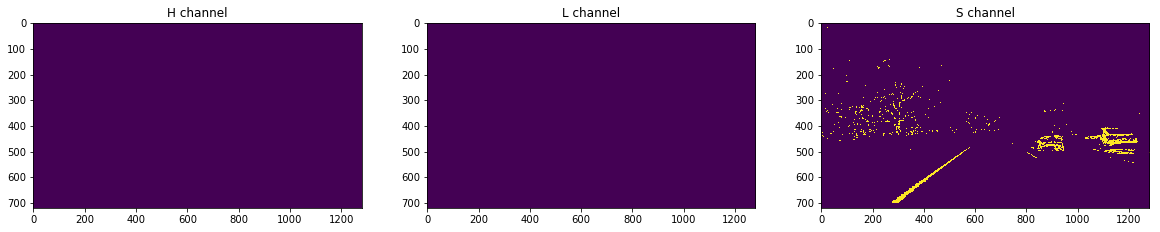

In [24]:
HLS_img = cv2.cvtColor(undist_img, cv2.COLOR_BGR2HLS)
#plt.imshow(HLS_img)
H = HLS_img[:,:,0]
L = HLS_img[:,:,1]
S = HLS_img[:,:,2]

binary_H = np.zeros_like(H)
binary_L = np.zeros_like(L)
binary_S = np.zeros_like(S)

#binary_H[(H >= 90) & (H <=255)]=1
#binary_L[(L >= 90) & (L <=255)]=1
binary_S[(S >= 170) & (S <=255)]=1
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(binary_H)
ax1.set_title('H channel')
ax2.imshow(binary_L)
ax2.set_title('L channel')
ax3.imshow(binary_S)
ax3.set_title('S channel')

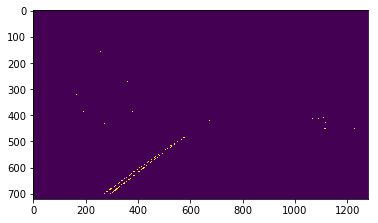

In [25]:
color_grad_comb = np.zeros_like(binary_S)
color_grad_comb[(binary_S==1) & (binary_combine==1)]=1
plt.imshow(color_grad_comb)

In [ ]:
src = [corners[0],corners[],corners[],corners[53]]
dst = [[100,100],[1200,100],[1200,700],[100,700]]
M = cv2.getPerspectiveTransform(src, dst)
warped_img = cv2.warpPerspective(undist_img, M, (undist_img[1],undist_img[0]))